In [ ]:
%%time
import torch
import torch.multiprocessing as mp
at = [ torch.zeros(10) for i in range(5) ]
#print(at)

def forward(a):
    print(a)
    #q.get()#1+1
    #q.put( q.get()+2 )

# NOTE: this is required for the ``fork`` method to work
if __name__ == '__main__':
    processes = []
    queues = []
    #x = torch.zeros_like(a[0])
    #x.share_memory()
    for a in at:
        q = mp.Queue(a)
        p = mp.Process(target=forward, args=(q))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
    #print(args)
    #print(x)
    #for q in queues:
    #   print(q.get())

In [ ]:
import multiprocessing as mp
import torch

done = mp.Event()

def extractor_worker(done_queue):
    done_queue.put(torch.Tensor(10,10))
    done_queue.put(None)
    done.wait()

producers = []
done_queue = mp.Queue()
for i in range(0, 1):
    process = mp.Process(target=extractor_worker,
                         args=(done_queue,))
    process.start()
    producers.append(process)

    for p in producers:
        p.join()


In [ ]:
import numpy as np
import torch
import torch.multiprocessing as mp

torch.set_grad_enabled(False)

def target(inputs, outputs):
    x = inputs.get()
    outputs.put(x)
    outputs.join()

inputs = mp.Queue(1)
outputs = mp.JoinableQueue(1)

value = torch.tensor([1., 2.])

inputs.put(value)
proc = mp.Process(target=target, args=(inputs, outputs))
proc.start()
x = outputs.get()
outputs.task_done()
proc.join()
print(x)


In [ ]:
import torch
x = torch.Tensor(3,3)
x

True
False


(array([8.00000e+00, 1.20000e+01, 1.00700e+03, 2.63000e+04, 2.88275e+05,
        7.03146e+05, 2.88260e+04, 9.81000e+02, 1.60000e+01, 5.00000e+00]),
 array([-4.7683716e-07, -3.8146973e-07, -2.8610231e-07, -1.9073487e-07,
        -9.5367433e-08,  0.0000000e+00,  9.5367433e-08,  1.9073487e-07,
         2.8610231e-07,  3.8146973e-07,  4.7683716e-07], dtype=float32),
 <BarContainer object of 10 artists>)

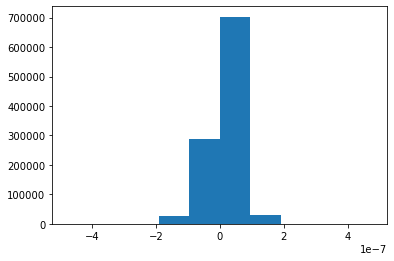

In [ ]:
import torch
import torch.nn as nn
import timeit, matplotlib.pyplot as plt


def count_params(model):
    """Count the number of parameters in a module."""
    return sum([p.numel() for p in model.parameters()])


def compare_params(linear, conv1d):
    """Compare whether two modules have identical parameters."""
    return (linear.weight.detach().numpy() == conv1d.weight.detach().numpy().squeeze()).all() and \
           (linear.bias.detach().numpy() == conv1d.bias.detach().numpy()).all()


def compare_tensors(out_linear, out_conv1d):
    """Compare whether two tensors are identical."""
    return (out_linear.detach().numpy() == out_conv1d.permute(0, 2, 1).detach().numpy()).all()
conv1d, linear = nn.Conv1d(8, 32, 1), nn.Linear(8, 32)

# same input tensor
tensor = torch.randn(128, 256, 8)
permuted_tensor = tensor.permute(0, 2, 1).clone().contiguous()

# same weights and bias
linear.weight = nn.Parameter(conv1d.weight.squeeze(2))
linear.bias = nn.Parameter(conv1d.bias)
print(compare_params(linear, conv1d))  # True

# check on the forward tensor
out_linear = linear(tensor)  # torch.Size([128, 256, 32])
out_conv1d = conv1d(permuted_tensor)  # torch.Size([128, 32, 256])
print(compare_tensors(out_linear, out_conv1d))  # False
plt.hist((out_linear.detach().numpy() - out_conv1d.permute(0, 2, 1).detach().numpy()).ravel())

(array([ 136.,  437.,  773., 1146., 1487., 1721., 1146.,  773.,  437.,
         136.]),
 array([-4.4280082e-02, -3.5424065e-02, -2.6568051e-02, -1.7712034e-02,
        -8.8560190e-03, -3.7252903e-09,  8.8560116e-03,  1.7712027e-02,
         2.6568044e-02,  3.5424057e-02,  4.4280075e-02], dtype=float32),
 <BarContainer object of 10 artists>)

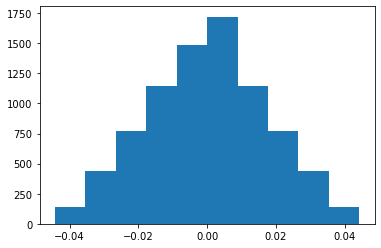

In [ ]:
target = torch.randn(out_linear.shape)
permuted_target = target.permute(0, 2, 1).clone().contiguous()

loss_linear = nn.MSELoss()(target, out_linear)
loss_linear.backward()
loss_conv1d = nn.MSELoss()(permuted_target, out_conv1d)
loss_conv1d.backward()

plt.hist((linear.weight.grad.detach().numpy() - 
    conv1d.weight.grad.permute(0, 2, 1).detach().numpy()).ravel())

In [ ]:
# test execution speed on CPUs
print(timeit.timeit("_ = linear(tensor)", number=10000, setup="from __main__ import tensor, linear"))
print(timeit.timeit("_ = conv1d(permuted_tensor)", number=10000, setup="from __main__ import conv1d, permuted_tensor"))

# change everything in *.cuda(), then test speed on GPUs


4.132530886999973
10.607492321999985


In [ ]:
tensor.shape,permuted_tensor.shape

(torch.Size([128, 256, 8]), torch.Size([128, 8, 256]))